In [38]:
import torch
from PIL import Image
import torchvision.io as io
import torchvision.transforms
import os
import matplotlib.animation
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  

Import de Vidéo

In [39]:
dataset_dir = ".\\SomeEx"
video_files = [f for f in os.listdir(dataset_dir) if f.endswith('.mp4')]

videos = []
NbToLoad = 2

loadded = 0
for video_name in video_files:
    print("Loading",video_name)
    video, audio, info = io.read_video(dataset_dir + "/" + video_name, pts_unit='sec')
    videos.append(video)
    loadded += 1
    if (loadded >= NbToLoad):
        break
    
print("Done")

Loading aaa.mp4
Loading actccqfmac.mp4
Done


In [40]:
import torchvision.transforms as transforms


def ToPILImage(frame):
    return transforms.ToPILImage()(frame.numpy())

def ResizePIL(img, size):
    return img.resize((size, size*img.size[1]//img.size[0]), Image.Resampling.LANCZOS)

In [41]:
target_video = videos[1]

In [42]:
plt.ioff()
NbFrames = 10

def filtre(x,t):
    return x[5+t] - 2* x[3+t] + x[t]

fig, ax = plt.subplots()
def animate(t):
    plt.cla()
    plt.imshow(target_video[t])
matplotlib.animation.FuncAnimation(fig, animate, frames=NbFrames)

# img = ResizePIL(ToPILImage(target_video[t]),200)
# img = ToPILImage(target_video[t])


In [43]:
plt.ioff()
NbFrames = 8


def get_img(t):
    return np.array(ResizePIL(ToPILImage(target_video[t]),200).convert('L'))

# les dérivées
#images_resized = np.array([get_img(t+8)-2*get_img(t+4)+get_img(t) for t in range(NbFrames)])
images_resized = np.array([get_img((t+1)*2)-0.8*get_img(t*2) for t in range(NbFrames)])


# les std sur des petits carré
images_std_clust = np.zeros_like(images_resized)
hsize = 2
for t in range(len(images_resized)):
    print("image", t)
    for x in range(len(images_resized[0])):
        xmin = max(0,x-hsize)
        xmax = min(len(images_resized[0]),x+hsize)
        for y in range(len(images_resized[0][0])):
            ymin = max(0,y-hsize)
            ymax = min(len(images_resized[0,0]),y+hsize)
            images_std_clust[:,x,y] = np.std(images_resized[:,xmin:xmax,ymin:ymax], axis=(1,2))

print("done image")

cur_imgs = []

fig, ax = plt.subplots()
def animate(t):
    global cur_imgs
    plt.cla()
    #cur_imgs.append(get_img(t+1)-get_img(t))
    #max_ = np.max(cur_imgs[-1])
    min_ = np.min(images_std_clust[t])
    max_ = np.max(images_std_clust[t])
    #cur_imgs[-1] = (cur_imgs[-1]-min_)/(max_-min_)
    #plt.imshow(np.clip(images_std_clust[t], min_+(max_-min_)*0.1, max_-(max_-min_)*0.5))
    plt.imshow(images_std_clust[t])
matplotlib.animation.FuncAnimation(fig, animate, frames=NbFrames)

# img = ResizePIL(ToPILImage(target_video[t]),200)
# img = ToPILImage(target_video[t])

image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
done image


cur_imgs (8, 112, 200)


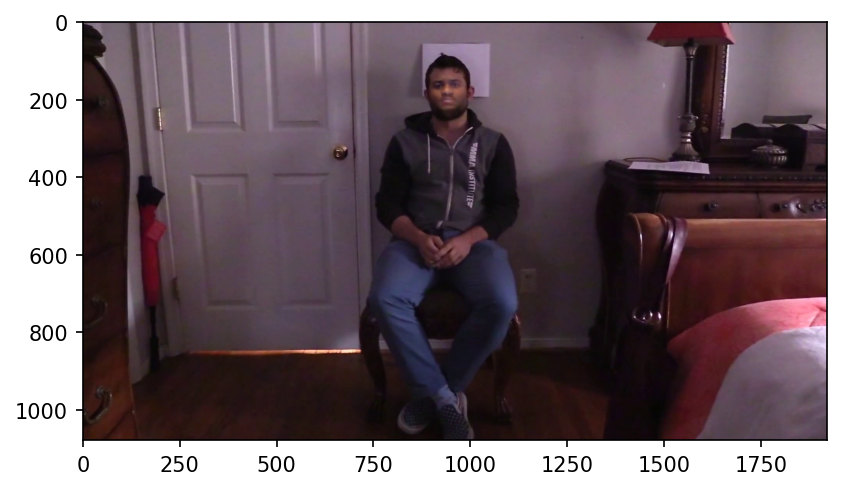

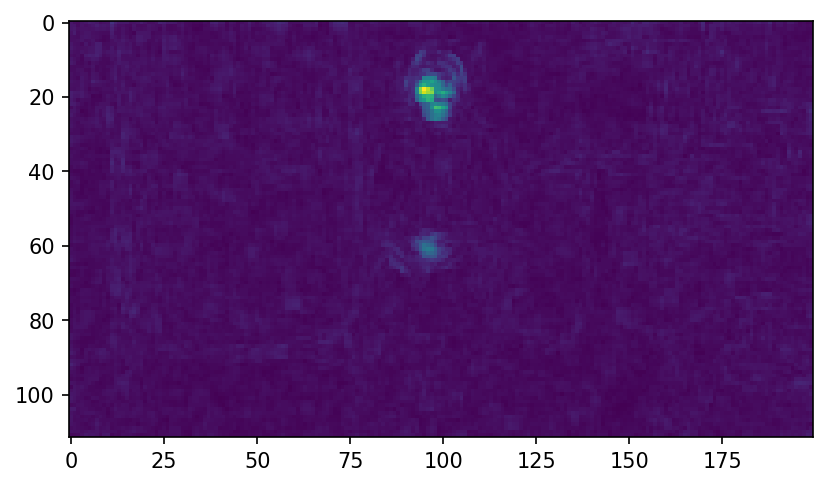

In [44]:
cur_imgs = np.array(images_std_clust)

print("cur_imgs",cur_imgs.shape)

img_dev = np.std(images_std_clust, axis=(0))

plt.imshow(img_dev)
plt.show()

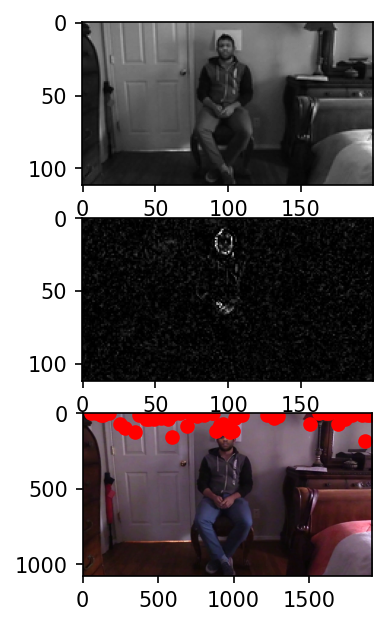

In [45]:
# Detect mouvement area

def sensing_fct(image):
    maxv = np.max(image)
    minv = np.min(image)
    seuil = int(minv+(maxv-minv)/2)
    #return np.clip(image, seuil, maxv)
    return np.where(image>seuil, 0,image)

def get_relevant_points(video, display=False):
    # Load Low quality
    rvideo = []
    LowQualitySize = 200

    for i in range(20):
        rvideo.append(np.array(ResizePIL(ToPILImage(video[i]), LowQualitySize).convert('L')))
    rvideo = np.array(rvideo)

    original_w, original_h = ToPILImage(video[0]).size

    def get_pos_hd(x, y):
        # Return pixel position in hd frame from ld coordonates
        return [int(x*(original_w/LowQualitySize)), int(y*original_h/(LowQualitySize*(original_h/original_w)))]

    # Get Mvt from start frame
    first_frame = rvideo[0]
    gap_frame = np.zeros_like(first_frame)

    for i in range(1,len(rvideo)):
        gap_frame += sensing_fct(np.abs(first_frame - rvideo[i]))

    if (display):
        plt.subplot(3,1,1)
        plt.imshow(rvideo[0], cmap='gray')
        plt.subplot(3,1,2)
        plt.imshow(gap_frame, cmap='gray')
        #plt.imshow(gap_frame, cmap='gray')
        plt.subplot(3,1,3)
        plt.imshow(ToPILImage(video[0]), cmap='gray')

    # Puis on se fait des bande verticales

    Nbandes = 120
    StdNormalisedNoMvt = 0.2

    def find_hit_y(x):
        # return the first place where mvt
        slice = gap_frame[:,x]
        max_slice = np.max(slice)
        min_slice = np.min(slice)
        delta_slice = max_slice - min_slice
        seuil = min_slice + delta_slice*0.2
        for idx in range(len(slice)):
            if slice[idx] > seuil:
                return idx, np.std(slice)
        return 0, 0
    
    y_hits = []
    x_hits = []
    gap_slices = []

    for col in range(1,Nbandes+1):
        x_hits.append(int(col*len(gap_frame[0])/(Nbandes+1)))
        y_hit, gap_slice = find_hit_y(x_hits[-1])
        y_hits.append(y_hit)
        gap_slices.append(gap_slice)

    # gap_slices contient à quelle point une tranche est de mouvement uniforme
    # on normalise pour virer les tranches qui ne bougent pas
    gap_slices = gap_slices/np.max(gap_slices)
    relevant_points = []

    for col in range(Nbandes):
        # Generate the 3 sampling points

        if (gap_slices[col] > StdNormalisedNoMvt): # ca bouge pas assez
            relevant_points.append(get_pos_hd(x_hits[col],y_hits[col]))

    relevant_points = np.array(relevant_points)
    
    if (display):
        plt.plot(relevant_points[:,0],relevant_points[:,1],'ro')
        plt.show()

    return relevant_points

relevant_points = get_relevant_points(target_video, True)


112 200


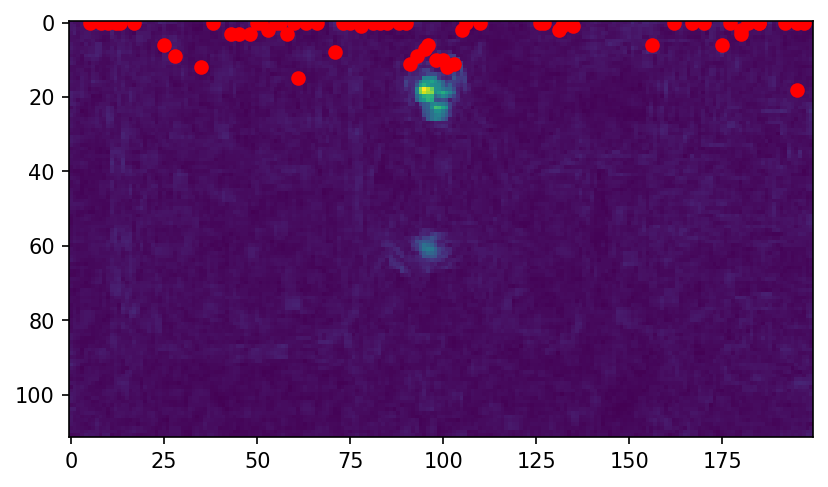

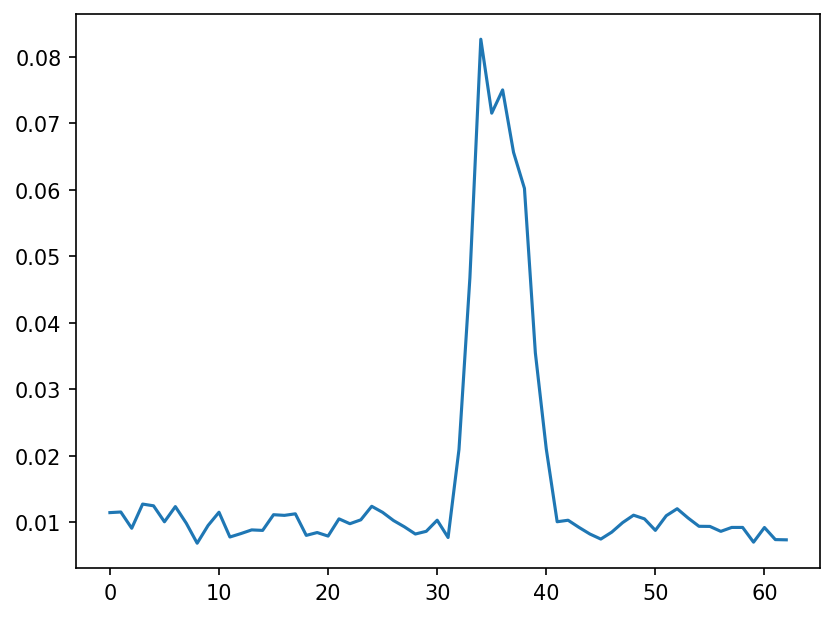

In [46]:
#Finish with relevant_points

#relevant_points

original_w, original_h = ToPILImage(target_video[0]).size
img_dev_h, img_dev_w = img_dev.shape

print(img_dev_h, img_dev_w)

def in_std_ld_ref(pt):
    (x,y) = pt
    return (min(img_dev_w-1,int(img_dev_w*x/original_w)),int(img_dev_h*y/original_h))

# on fait la moyenne sur les bandes
std_slice = []
for pt in relevant_points:
    beacon = in_std_ld_ref(pt)
    plt.plot(beacon[0],beacon[1],'ro')

    mini_slice = img_dev[beacon[1]:min(beacon[1]+15, img_dev_h),beacon[0]]

    std_slice.append(np.sum(mini_slice))

plt.imshow(img_dev)
plt.show()

std_slice = std_slice/np.sum(std_slice)

plt.plot(std_slice)
plt.show()


In [47]:
DeepFake = False
if (np.max(std_slice) > 4*np.mean(std_slice)):
    DeepFake = True

print("DeepFake",DeepFake)

DeepFake True


In [48]:
mm = int(0.1 * len(std_slice))
thresold = 2
if (mm > 2):
    thresold = mm
sorted = np.argsort(std_slice)
candidates = sorted[-thresold:]

candidates = np.sort(candidates)
print(candidates)


#DeepFake = False

limiteTheo = 3
limiteTheo2 = 1.2

still_adj = False
last_still_adj = False
lengthplat = 2
index = -1
for i in range(1,len(candidates)):
    if candidates[i-1]+1==candidates[i]:
        index, current_max, i = i-1, 2, i+1
    while i < len(candidates) and candidates[i-1]+1==candidates[i]:
        current_max += 1
        i +=1
        if current_max > lengthplat:
            lengthplat = current_max

print("lengthplat",lengthplat)

plateau = [i for i in range (index, index+lengthplat)]
if lengthplat > limiteTheo and np.mean(np.array(plateau)) > limiteTheo2 * np.mean(np.array(std_slice)):
    DeepFake = True

print()
print("------------")

if (DeepFake):
    print("C'est bon Fréro c'est bien de la MERDE ce que tu vois")
else:
    print("Tkt Frère tu PEUX regarder")
print("------------")


[33 34 35 36 37 38]
lengthplat 6

------------
C'est bon Fréro c'est bien de la MERDE ce que tu vois
------------


In [49]:
# Open FFT !